# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Ayesha Zafar

*Semester:* Fall 2025

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
import seaborn as sns

2025-12-12 23:32:27.715914: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/CSS_New/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

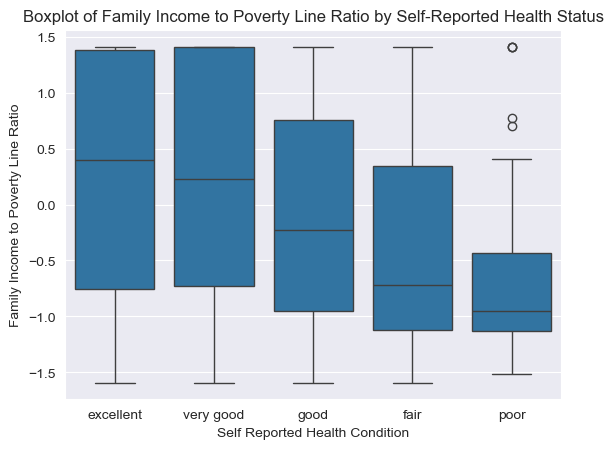

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

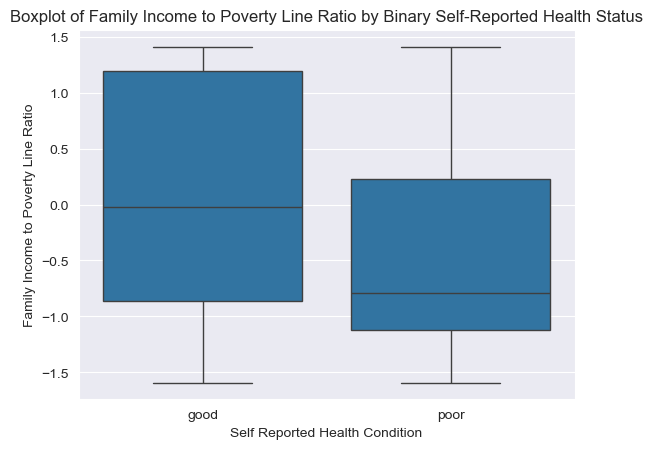

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

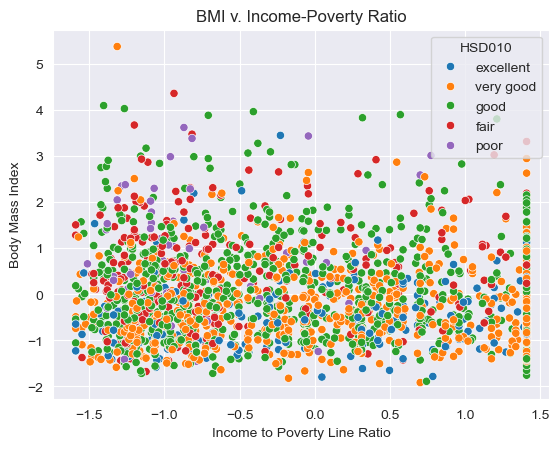

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
nhanes_scaled_USML = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)
nhanes_scaled_USML.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ033,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812


## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

#### Choose the number of components and provide 1-2 sentences about your choice of the number of components. 


### I chose to fit PCA using all available components in order to examine the full variance structure of the NHANES dataset. This allows me to assess how variance is distributed across components and to determine an appropriate cutoff for the machine learning model

In [7]:

pca_all = PCA()
pca_all.fit(nhanes_scaled_USML)


,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


### Barplot of Components

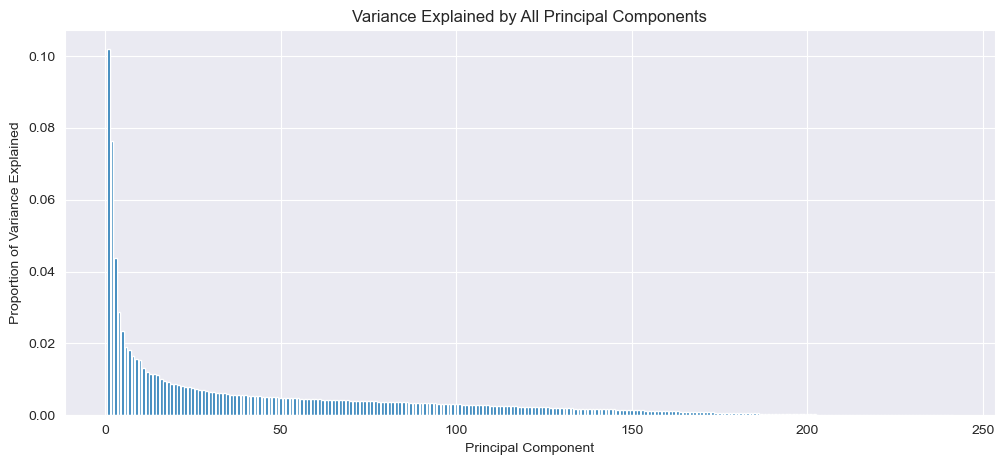

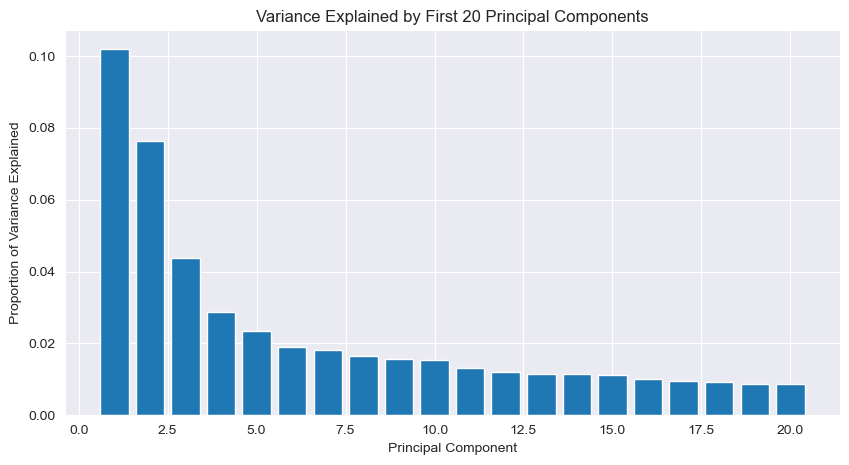

In [8]:
components = np.arange(1, len(pca_all.explained_variance_ratio_) + 1)

plt.figure(figsize=(12, 5))
plt.bar(components, pca_all.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Variance Explained by All Principal Components')
plt.show()

# Graphing the first 20 for readability
k = 20

variance_explained = pca_all.explained_variance_ratio_[:k]
components = np.arange(1, 
                       k + 1)

plt.figure(figsize=(10, 5))
plt.bar(components, variance_explained)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Variance Explained by First 20 Principal Components')
plt.show()

### How many components will you use to fit a supervised learning model?

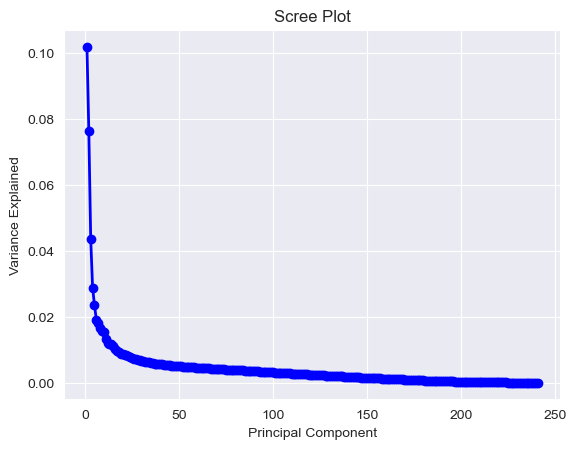

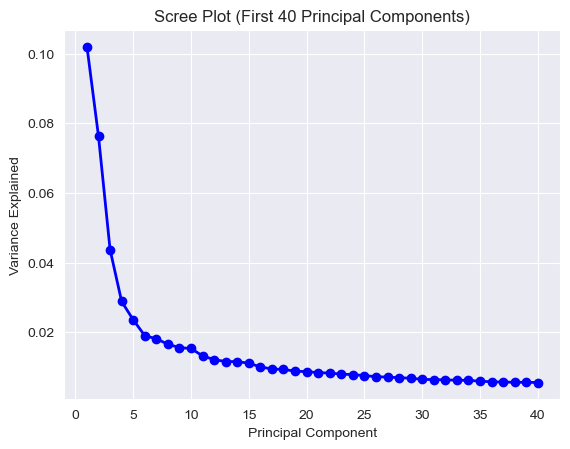

In [9]:
# Scree Plot

PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 
         'o-', 
         linewidth=2, 
         color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# Looking at the first 40 components for visibility

k = 40
PC_values = np.arange(k) + 1

plt.plot(
    PC_values,
    pca_all.explained_variance_ratio_[:k], 
    'o-',
    linewidth=2,
    color='blue'
)
plt.title('Scree Plot (First 40 Principal Components)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()


In [10]:
cumulative_variance = np.cumsum(pca_all.explained_variance_ratio_)
for threshold in [0.8, 0.85, 0.90, 0.95]:
    print(threshold, np.argmax(cumulative_variance >= threshold) + 1)
    

0.8 86
0.85 101
0.9 120
0.95 145


### I initially tried to create a scree plot. According to the graph, I would place the elbow somewhere between 15-20; however, that would explain less then 1% of variance. Therefore, I then switched to using cumulative variance. I chose 145 principal components, which together explain approximately 95% of the total variance in the data. These are the number of components I am going to use for my machine learning model. 

In [11]:
pca_ML = PCA(n_components=145, random_state=10)
nhanes_pca = pca_ML.fit_transform(nhanes_scaled_USML)

### 2D Scatterplot of the first two components

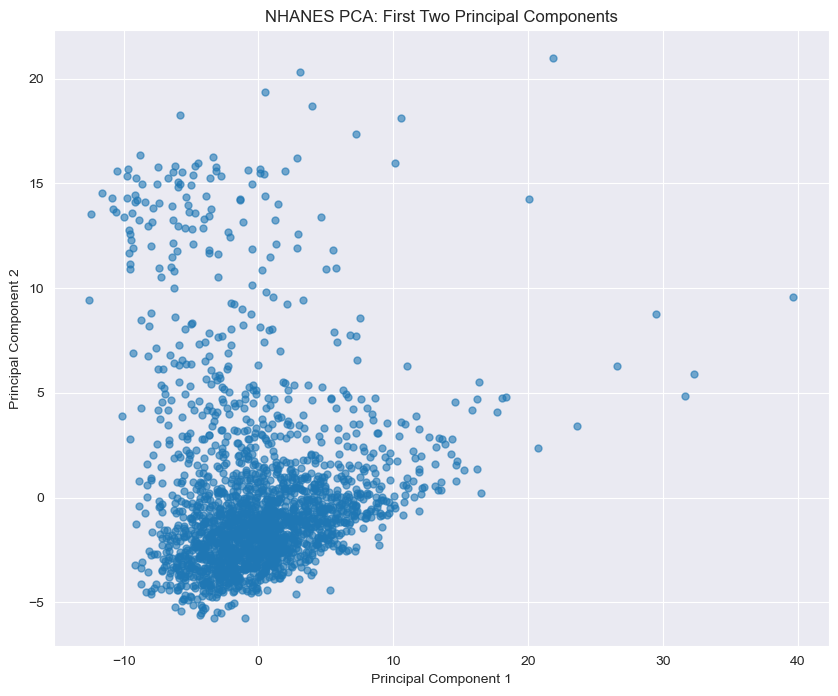

In [12]:

# Project NHANES data into PCA space
pca_scores = pca_all.transform(nhanes_scaled_USML)

# Create dataframe with first two PCs
pca_df = pd.DataFrame({
    "PC1": pca_scores[:, 0],
    "PC2": pca_scores[:, 1],
})

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(pca_df["PC1"], pca_df["PC2"], s=25, alpha=0.6)
plt.title("NHANES PCA: First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

### The scatterplot shows a dense, continuous distribution with no clear clustering, indicating that the first two principal components capture broad population-level variation rather than distinct subgroups. The elongated spread along the first component suggests it explains substantially more variance than the second, consistent with PCA’s role as an unsupervised dimensionality-reduction method.

## Clustering

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

### I choose k-means clustering, which partitions observations into a pre-specified number of clusters. It is well suited for this analysis because the NHANES variables are continuous, scaled, and we aim to identify broad patterns rather than hierarchical or density-based structure.

### Cluster nhanes

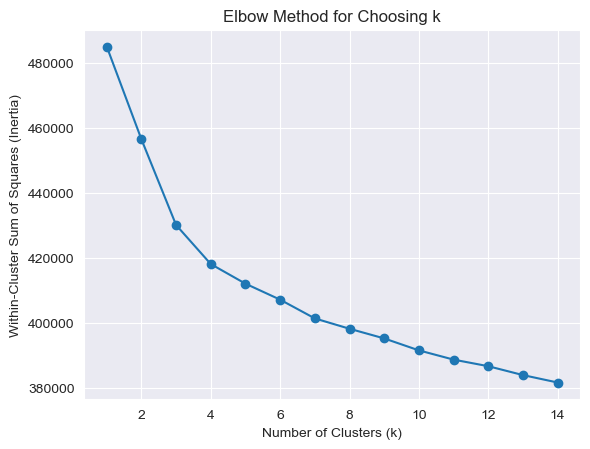

In [13]:
k_values = range(1, 15)
inertia = []

for k in k_values:
    kmeans = KMeans(n_clusters=k,
                    random_state=42)
    kmeans.fit(nhanes_scaled_USML)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure()
plt.plot(k_values, inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (Inertia)")
plt.title("Elbow Method for Choosing k")
plt.show()

### I chose k=4 because the elbow curve shows large decreases in inertia up to around 4 clusters, after which additional clusters yield diminishing returns.

In [14]:
# Fit k-means with chosen number of clusters (k = 4)
kmeans = KMeans(
    n_clusters=4,
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(nhanes_scaled_USML)


,n_clusters,4
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

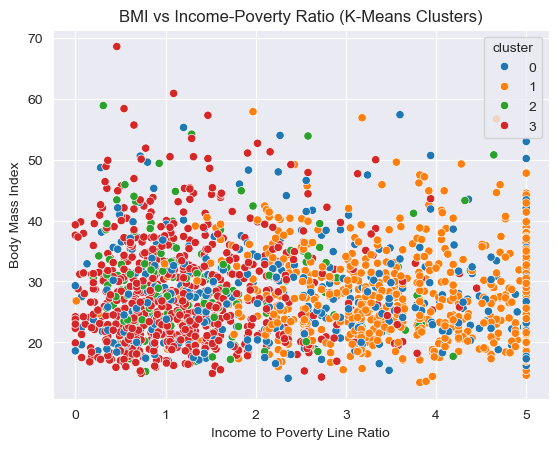

In [15]:
# Add cluster labels to the dataframe you're plotting from
nhanes["cluster"] = kmeans.labels_

ax = sns.scatterplot(
    x="INDFMPIR",
    y="BMXBMI",
    hue="cluster",
    palette="tab10",
    data=nhanes
)

ax.set(xlabel="Income to Poverty Line Ratio", ylabel="Body Mass Index")
ax.set_title("BMI vs Income-Poverty Ratio (K-Means Clusters)")
plt.show()

### The clusters overlap considerably in BMI–income space, indicating that BMI and income alone do not determine cluster membership. While some clusters are more prevalent at higher or lower income levels, the substantial overlap suggests that the k-means clusters reflect broader, multidimensional health and socioeconomic profiles rather than simple separations along BMI or income.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

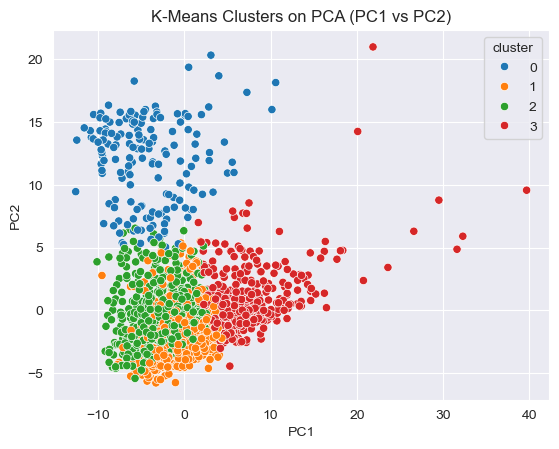

In [16]:
kmeans_PCA = KMeans(
    n_clusters=4,
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans_PCA.fit(nhanes_pca)

pca_plot_df = pd.DataFrame({
    "PC1": nhanes_pca[:, 0],
    "PC2": nhanes_pca[:, 1],
    "cluster": kmeans_PCA.labels_
})

# 4) Plot clusters on top of the 2D PCA scatterplot
ax = sns.scatterplot(x="PC1", y="PC2", hue="cluster", palette="tab10", data=pca_plot_df)
ax.set_title("K-Means Clusters on PCA (PC1 vs PC2)")
plt.show()

### The PCA-based clustering plot shows clearer and more compact separation between clusters than the raw-variable plots, particularly along the first principal component. This indicates that PCA concentrates the dominant sources of variation in the NHANES data, allowing k-means to identify latent structure that is not visible when clustering on individual variables alone.

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [17]:
# partition data
# -----------

nhanes_scaled['HSD010_binary_num'] = nhanes_scaled['HSD010_binary'].map({
    'poor': 0,
    'good': 1
})

y = nhanes_scaled['HSD010_binary_num'] # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 

X = nhanes_scaled.drop(
    columns=['HSD010', 'HSD010_binary', 'HSD010_binary_num']
) # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)



In [18]:

num_classes = 2

# convert class vectors to binary class matrices

y_train = to_categorical(y_train, num_classes)
y_test  = to_categorical(y_test,  num_classes)

In [19]:
# create neural network model
# -----------

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, kernel_initializer="normal", activation="relu"),
    Dense(num_classes, kernel_initializer="normal", activation="softmax"),
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32,   
    verbose=2
)

Epoch 1/10
49/49 - 1s - 21ms/step - accuracy: 0.7946 - loss: 0.4796 - val_accuracy: 0.8566 - val_loss: 0.3621
Epoch 2/10
49/49 - 0s - 3ms/step - accuracy: 0.8753 - loss: 0.3323 - val_accuracy: 0.8624 - val_loss: 0.3395
Epoch 3/10
49/49 - 0s - 3ms/step - accuracy: 0.8902 - loss: 0.2833 - val_accuracy: 0.8721 - val_loss: 0.3244
Epoch 4/10
49/49 - 0s - 3ms/step - accuracy: 0.9005 - loss: 0.2444 - val_accuracy: 0.8721 - val_loss: 0.3250
Epoch 5/10
49/49 - 0s - 3ms/step - accuracy: 0.9141 - loss: 0.2115 - val_accuracy: 0.8682 - val_loss: 0.3242
Epoch 6/10
49/49 - 0s - 3ms/step - accuracy: 0.9270 - loss: 0.1805 - val_accuracy: 0.8547 - val_loss: 0.3370
Epoch 7/10
49/49 - 0s - 3ms/step - accuracy: 0.9425 - loss: 0.1584 - val_accuracy: 0.8605 - val_loss: 0.3493
Epoch 8/10
49/49 - 0s - 3ms/step - accuracy: 0.9567 - loss: 0.1302 - val_accuracy: 0.8624 - val_loss: 0.3563
Epoch 9/10
49/49 - 0s - 3ms/step - accuracy: 0.9658 - loss: 0.1106 - val_accuracy: 0.8605 - val_loss: 0.3778
Epoch 10/10
49/49 

### The neural network fits the training data extremely well (accuracy approaches 99%), but validation accuracy plateaus around 86–87% while validation loss increases after the early epochs, indicating overfitting. The best generalisation performance appears around epochs 3–5, suggesting the model should be stopped earlier or regularised further.

### Neural Network on Principal Components

In [20]:
nhanes_scaled['HSD010_binary_num'] = nhanes_scaled['HSD010_binary'].map({'poor': 0, 'good': 1})
y = nhanes_scaled['HSD010_binary_num'] 
y = nhanes_scaled.loc[nhanes_scaled_USML.index, 'HSD010_binary_num']

# features for PCA (already no outcome vars)
X_features = nhanes_scaled_USML

# --- 3) Train/test split (do this BEFORE PCA to avoid leakage) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.25, random_state=10
)

X_train_pca = pca_ML.fit_transform(X_train)
X_test_pca  = pca_ML.transform(X_test)

In [21]:
num_classes = 2
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test,  num_classes)


In [22]:
model = Sequential([
    Input(shape=(X_train_pca.shape[1],)),
    Dense(64, kernel_initializer="normal", activation="relu"),
    Dense(num_classes, kernel_initializer="normal", activation="softmax"),
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(
    X_train_pca, y_train_cat,
    validation_data=(X_test_pca, y_test_cat),
    epochs=10,
    batch_size=32,
    verbose=2
)

Epoch 1/10
49/49 - 1s - 17ms/step - accuracy: 0.8269 - loss: 0.4779 - val_accuracy: 0.8527 - val_loss: 0.3789
Epoch 2/10
49/49 - 0s - 3ms/step - accuracy: 0.8624 - loss: 0.3279 - val_accuracy: 0.8663 - val_loss: 0.3359
Epoch 3/10
49/49 - 0s - 3ms/step - accuracy: 0.8973 - loss: 0.2654 - val_accuracy: 0.8643 - val_loss: 0.3276
Epoch 4/10
49/49 - 0s - 3ms/step - accuracy: 0.9089 - loss: 0.2270 - val_accuracy: 0.8643 - val_loss: 0.3286
Epoch 5/10
49/49 - 0s - 3ms/step - accuracy: 0.9238 - loss: 0.1969 - val_accuracy: 0.8663 - val_loss: 0.3357
Epoch 6/10
49/49 - 0s - 3ms/step - accuracy: 0.9335 - loss: 0.1722 - val_accuracy: 0.8682 - val_loss: 0.3455
Epoch 7/10
49/49 - 0s - 3ms/step - accuracy: 0.9438 - loss: 0.1525 - val_accuracy: 0.8682 - val_loss: 0.3544
Epoch 8/10
49/49 - 0s - 3ms/step - accuracy: 0.9567 - loss: 0.1309 - val_accuracy: 0.8682 - val_loss: 0.3720
Epoch 9/10
49/49 - 0s - 2ms/step - accuracy: 0.9658 - loss: 0.1123 - val_accuracy: 0.8682 - val_loss: 0.3788
Epoch 10/10
49/49 

### When training the neural network on PCA components only, training accuracy increased steadily while validation accuracy stabilised around 87–88%, with validation loss rising more gradually than in the full-feature model. This indicates milder overfitting and slightly improved generalisation, suggesting that PCA helps reduce noise and redundancy in the feature space.

### Neural Network on Principal Components + Cluster Membership

In [25]:
y = nhanes_scaled.loc[nhanes_scaled_USML.index, 'HSD010_binary'].map({'poor': 0, 'good': 1})

# --- Base feature matrix (no outcome cols) ---
X_features = nhanes_scaled_USML

# --- Split BEFORE fitting PCA or k-means (avoid leakage) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y, test_size=0.25, random_state=10
)

X_train_pca = pca_ML.fit_transform(X_train)
X_test_pca  = pca_ML.transform(X_test)

kmeans.fit(X_train)                       # fits on original scaled features
train_cluster = kmeans.predict(X_train)   # labels for train
test_cluster  = kmeans.predict(X_test)    # labels for test

X_train_combo = np.column_stack([X_train_pca, train_cluster])
X_test_combo  = np.column_stack([X_test_pca,  test_cluster])

In [24]:
num_classes = 2
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test,  num_classes)

model = Sequential([
    Input(shape=(X_train_combo.shape[1],)),
    Dense(64, kernel_initializer="normal", activation="relu"),
    Dense(num_classes, kernel_initializer="normal", activation="softmax"),
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(
    X_train_combo, y_train_cat,
    validation_data=(X_test_combo, y_test_cat),
    epochs=10,
    batch_size=32,
    verbose=2
)


Epoch 1/10
49/49 - 1s - 17ms/step - accuracy: 0.7623 - loss: 0.5271 - val_accuracy: 0.8508 - val_loss: 0.3835
Epoch 2/10
49/49 - 0s - 3ms/step - accuracy: 0.8630 - loss: 0.3320 - val_accuracy: 0.8682 - val_loss: 0.3397
Epoch 3/10
49/49 - 0s - 3ms/step - accuracy: 0.8928 - loss: 0.2707 - val_accuracy: 0.8605 - val_loss: 0.3291
Epoch 4/10
49/49 - 0s - 3ms/step - accuracy: 0.9050 - loss: 0.2317 - val_accuracy: 0.8547 - val_loss: 0.3300
Epoch 5/10
49/49 - 0s - 3ms/step - accuracy: 0.9244 - loss: 0.2003 - val_accuracy: 0.8585 - val_loss: 0.3349
Epoch 6/10
49/49 - 0s - 3ms/step - accuracy: 0.9367 - loss: 0.1776 - val_accuracy: 0.8605 - val_loss: 0.3436
Epoch 7/10
49/49 - 0s - 3ms/step - accuracy: 0.9470 - loss: 0.1533 - val_accuracy: 0.8624 - val_loss: 0.3519
Epoch 8/10
49/49 - 0s - 3ms/step - accuracy: 0.9606 - loss: 0.1332 - val_accuracy: 0.8643 - val_loss: 0.3625
Epoch 9/10
49/49 - 0s - 3ms/step - accuracy: 0.9651 - loss: 0.1147 - val_accuracy: 0.8702 - val_loss: 0.3757
Epoch 10/10
49/49 

### When PCA components were combined with cluster membership as additional features, training accuracy increased steadily, but validation accuracy remained around 86–87% with rising validation loss after the early epochs. This suggests that while cluster membership adds some structural information, it does not substantially improve generalisation beyond PCA alone and does not prevent overfitting.

### Across the three neural network specifications, all models achieved strong training performance, but they differed meaningfully in their ability to generalise to unseen data. The model trained on the original feature set quickly overfit, achieving very high training accuracy but plateauing at around 86–87% validation accuracy, suggesting that the high-dimensional raw feature space contained substantial noise and redundancy. Using PCA components alone produced slightly higher and more stable validation accuracy with slower growth in validation loss, indicating improved generalisation through dimensionality reduction. Adding cluster membership to the PCA features did not meaningfully improve validation performance beyond PCA alone, implying that the cluster structure was largely already captured by the principal components. Overall, the PCA-only featurisation provides the best balance between predictive performance and generalisation, and would be preferred due to its ability to reduce noise and overfitting while retaining most of the relevant information in the data.

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

### PCA and clustering address different goals in data analysis. PCA is a dimensionality-reduction technique that transforms the data into a smaller set of continuous components that summarise the main sources of variation, whereas clustering is a grouping method that assigns observations to discrete groups based on similarity.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

### Yes, combining PCA and clustering had clear advantages. PCA reduced noise and redundancy in the high-dimensional NHANES data by concentrating the most informative variation into a smaller set of components, which allowed k-means to form tighter and more clearly separated clusters than when clustering on the original feature space.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

### Unsupervised techniques can help downstream supervised learning by uncovering structure in high-dimensional data before labels are used. Methods like PCA and clustering reduce dimensionality, remove noise, and create informative representations or features, which can improve model efficiency, stability, and generalisation when working with large and complex datasets.